**DISCLAIMER**

By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code (1) is not subject to SOC 1 and SOC 2 compliance audits, and (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional. Do not use this code to replace, substitute, or provide professional financial advice, or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.

# ESG - market risk

The future of finance goes hand in hand with social responsibility, environmental stewardship and corporate ethics. In order to stay competitive, Financial Services Institutions (FSI)  are increasingly  disclosing more information about their **environmental, social and governance** (ESG) performance. By better understanding and quantifying the sustainability and societal impact of any investment in a company or business, FSIs can mitigate reputation risk and maintain the trust with both their clients and shareholders. At Databricks, we increasingly hear from our customers that ESG has become a C-suite priority. This is not solely driven by altruism but also by economics: [Higher ESG ratings are generally positively correlated with valuation and profitability while negatively correlated with volatility](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/). In this demo, we offer a novel approach to sustainable finance by combining NLP techniques and graph analytics to extract key strategic ESG initiatives and learn companies' relationships in a global market and their impact to market risk calculations.

---
+ <a href="https://databricks.com/notebooks/esg_notebooks/01_esg_report.html">STAGE1</a>: Using NLP to extract key ESG initiatives PDF reports
+ <a href="https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html">STAGE2</a>: Introducing a novel approach to ESG scoring using graph analytics
+ <a href="https://databricks.com/notebooks/esg_notebooks/03_esg_market.html">STAGE3</a>: Applying ESG to market risk calculations
---

## Context
As reported in previous notebook (see <a href="https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html">STAGE2</a>), our framework for ESG scoring is generic enough to accommodate multiple use cases. Whilst core FSIs may consider their own company as a landmark to Page Rank in order to better evaluate reputational risks, asset managers could consider all their positions as landmarks to better assess the sustainability relative to each of their investments. In order to validate our initial assumption that [...] [higher ESG ratings are generally positively correlated with valuation and profitability while negatively correlated with volatility](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/), we create a synthetic portfolio made of random equities that we run through our ESG framework and combine with actual stock information retrieved from Yahoo Finance.

### Dependencies
As reported in below cell, we use multiple 3rd party libraries that must be made available across Spark cluster. **NOTE** The next cell assumes you are running this notebook on a Databricks cluster that does not make use of the ML runtime.  If using an ML runtime, please follow these [alternative steps](https://docs.databricks.com/libraries.html#workspace-library) to load libraries to your environment.

In [ ]:
dbutils.library.installPyPI('yfinance')
dbutils.library.installPyPI('numpy', '1.16.5')
dbutils.library.installPyPI('pandas', '0.23.4')
# dbutils.library.installPyPI('pyarrow', '0.10.0')
dbutils.library.restartPython()

# `STEP1`: Synthetic portfolio
We create a synthetic portfolio made of random equities that we run through our ESG framework and combine with actual stock information retrieved from Yahoo Finance. Note that we've manually cleansed this portfolio upfront to have company name matching our GDELT dataset.

In [ ]:
import pandas as pd
from io import StringIO

portfolio = """
symbol,organisation
STI,suntrust banks
BIG,big lots
PANW,palo alto networks
IT,gartner
AGN,allergan
FL,foot locker
STI.B,suntrust banks
PRH,prudential financial
CAT,caterpillar
VMW,vmware
CLGX,corelogic
MET,metlife
JWN,nordstrom
PJH,prudential financial
RHT,red hat
PLD,prologis
JCI,johnson controls
PEP,pepsico
NEE,nextera energy
MO,altria group
STI.A,suntrust banks
TSN,tyson foods
DAL,delta air lines
TVE,tennessee valley authority
AIG,american international group
TOT,total sa
PFE,pfizer
CMG,chipotle mexican grill
EFX,equifax
TSNU,tyson foods
UPS,united parcel service
PSO,pearson
AIG.W,american international group
CAH,cardinal health
MTN,vail resorts
BR,broadridge financial solutions
BLK,blackrock
EXPR,express
PRU,prudential financial
SPG,simon property group
BARC.L,barclays
JPM,jp morgan chase
MS,morgan stanley
GS,goldman sachs
HSBC,hsbc
C,citi
TD,td bank
BAC,bank of america
RY,rbc
MQG.AX,macquarie
LLOY.L,lloyds
SAN,santander"""

portfolio_df = pd.read_csv(StringIO(portfolio))
spark.createDataFrame(portfolio_df).createOrReplaceTempView('portfolio')

In [ ]:
%sql
SELECT COUNT(*) FROM esg_db.scores;

count(1)
4722


In [ ]:
%sql
CREATE OR REPLACE TEMPORARY VIEW esg_nyse_scores AS
SELECT 
  g.organisation,
  g.theme,
  g.total,
  g.days,
  g.esg,
  p.symbol
FROM esg_db.scores g
JOIN portfolio p
ON p.organisation = g.organisation;

SELECT * FROM esg_nyse_scores;

organisation,theme,total,days,esg,symbol
big lots,G,1135,304,1.5570179005052,BIG
palo alto networks,G,1276,355,1.4874847111955525,PANW
gartner,S,4957,449,2.139241742075081,IT
gartner,G,5958,456,2.085166332256828,IT
allergan,S,1723,368,0.6999319137613548,AGN
allergan,G,2302,400,0.6969462953598609,AGN
prudential financial,G,5152,364,0.6056435870536938,PRH
prudential financial,S,4154,327,0.7152126543439421,PRH
caterpillar,S,4282,429,0.988749887349241,CAT
caterpillar,E,2866,372,0.9847966699451035,CAT


# `STEP2`: Rebuild our global market network and compute ESG
In this section, we apply the exact same framework as reported earlier so don't be surprised by the lack of comments and refer to [previous notebook](https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html) for more information. Due to the nature of news analytics, it is not surprising to observe news publishing companies (such as Thomson Reuters or Bloomberg) or social networks (Facebook, Twitter) as strongly connected organisations. Not reflecting the true connections of a given business but rather explained by a simple co-occurrence in news articles, we filtering them out prior to our page rank process.

In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.graphframes.GraphFrame

// GDELT may consider multiple organisations from a NLP standpoint that we would like to ingore.
val blacklist = Set("united states", "european union", "reuters", "twitter", "facebook", "thomson reuters", "associated press", "new york times", "bloomberg")
val blacklist_b = spark.sparkContext.broadcast(blacklist)

// Cartesian products of organisations mentioned in a same news article
val buildTuples = udf((xs: Seq[String]) => {
  val organisations = xs.filter(x => !blacklist_b.value.contains(x))
  organisations.flatMap(x1 => {
    organisations.map(x2 => {
      (x1, x2)
    })
  }).toSeq.filter({ case (x1, x2) =>
    x1 != x2 // remove self edges
  })
})

// Generate our vertex dataset (organisations mentioned in news articles)
val nodes = spark
  .read
  .table("esg_db.scores")
  .select(col("organisation").as("id"))
  .distinct()

// Generate our edges (organisations shating common news articles more than 200 times)
val edges = spark.read.table("esg_db.gdelt_silver")
  .groupBy("url")
  .agg(collect_list(col("organisation")).as("organisations"))
  .withColumn("tuples", buildTuples(col("organisations")))
  .withColumn("tuple", explode(col("tuples")))
  .withColumn("src", col("tuple._1"))
  .withColumn("dst", col("tuple._2"))
  .groupBy("src", "dst")
  .agg(sum(lit(1)).as("relationship"))
  .filter(col("relationship") > 200)

// Create our graph object
val esgGraph = GraphFrame(nodes, edges)
println("Number of nodes : " + esgGraph.vertices.count()) //2,611
println("Number of edges : " + esgGraph.edges.count()) //97,212

Number of nodes : 2351
Number of edges : 88110
import org.apache.spark.sql.functions._
import org.graphframes.GraphFrame
blacklist: scala.collection.immutable.Set[String] = Set(bloomberg, reuters, united states, facebook, european union, twitter, new york times, associated press, thomson reuters)
blacklist_b: org.apache.spark.broadcast.Broadcast[scala.collection.immutable.Set[String]] = Broadcast(727)
buildTuples: org.apache.spark.sql.expressions.UserDefinedFunction = SparkUserDefinedFunction($Lambda$8811/2060583482@16b6ebbd,ArrayType(StructType(StructField(_1,StringType,true), StructField(_2,StringType,true)),true),List(Some(class[value[0]: array<string>])),None,true,true)
nodes: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string]
edges: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [src: string, dst: string ... 1 more field]
esgGraph: org.graphframes.GraphFrame = GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])

We want to compute the importance of each organisation relative to the different instruments in our portfolio. We will consider each of our instrument as a `landmark` to compute shortest path and page rank, leading to our weighted propagated ESG score introduced in previous notebook.

In [ ]:
%scala

// Consider our portfolio items as new landmarks
// These will be used to compute node influence via personalised page rank
val landmarks = spark
  .sql("SELECT DISTINCT organisation FROM esg_nyse_scores")
  .rdd
  .map(_.getAs[String]("organisation"))
  .collect()

// Make these landmarks available at executor level
val landmarks_b = spark.sparkContext.broadcast(landmarks)

landmarks: Array[String] = Array(allergan, pepsico, nextera energy, pearson, united parcel service, goldman sachs, prudential financial, td bank, citi, metlife, nordstrom, total sa, express, lloyds, santander, pfizer, simon property group, caterpillar, tyson foods, big lots, palo alto networks, red hat, equifax, chipotle mexican grill, jp morgan chase, barclays, corelogic, vmware, delta air lines, tennessee valley authority, broadridge financial solutions, blackrock, macquarie, gartner, morgan stanley)
landmarks_b: org.apache.spark.broadcast.Broadcast[Array[String]] = Broadcast(740)

In [ ]:
%scala

// Run shortest path algorithm with our portfolio items as landmarks
val shortestPaths = esgGraph
  .shortestPaths
  .landmarks(landmarks)
  .run()

// Limit our graph to at most 4 hops away from our landmarks
val filterDepth = udf((distances: Map[String, Int]) => {
  distances.values.exists(_ < 5)
})

// Filter graph
val esgDenseGraph = GraphFrame(shortestPaths, edges)
  .filterVertices(filterDepth(col("distances")))
  .cache()

shortestPaths: org.apache.spark.sql.DataFrame = [id: string, distances: map<string,int>]
filterDepth: org.apache.spark.sql.expressions.UserDefinedFunction = SparkUserDefinedFunction($Lambda$8822/859133570@1d575a05,BooleanType,List(Some(class[value[0]: map<string,int>])),None,false,true)
esgDenseGraph: org.graphframes.GraphFrame = GraphFrame(v:[id: string, distances: map<string,int>], e:[src: string, dst: string ... 1 more field])

Long process with 2.55 mins on huge cluster

In [ ]:
%scala

import org.apache.spark.ml.linalg.Vector

// Run personalised page rank with our portfolio as landmark
// This retrieve connections importance relative to our investments
val prNodes = esgDenseGraph
  .parallelPersonalizedPageRank
  .resetProbability(0.15)
  .maxIter(100)
  .sourceIds(landmarks.asInstanceOf[Array[Any]])
  .run()

// Retrieve importance to each of our investment
val importances = udf((pr: Vector) => {
  pr.toArray.zipWithIndex.map({ case (importance, id) =>
    (landmarks_b.value(id), importance)
  })
})

// Extract list of connections and their relative importance to our investments
val connections = prNodes
  .vertices
  .withColumn("importances", importances(col("pageranks")))
  .withColumn("importance", explode(col("importances")))
  .select(
    col("importance._1").as("organisation"),
    col("id").as("connection"),
    col("importance._2").as("importance")
  )

import org.apache.spark.ml.linalg.Vector
prNodes: org.graphframes.GraphFrame = GraphFrame(v:[id: string, distances: map<string,int> ... 1 more field], e:[src: string, dst: string ... 2 more fields])
importances: org.apache.spark.sql.expressions.UserDefinedFunction = SparkUserDefinedFunction($Lambda$8839/65931757@8b5e3c8,ArrayType(StructType(StructField(_1,StringType,true), StructField(_2,DoubleType,false)),true),List(Some(class[value[0]: vector])),None,true,true)
connections: org.apache.spark.sql.DataFrame = [organisation: string, connection: string ... 1 more field]

In [ ]:
%scala

// Create our weighted propagated ESG average 
// By bringing internal ESG for each connection proportional to their importance
spark
  .read
  .table("esg_db.scores")
  .withColumnRenamed("organisation", "connection")
  .join(connections, List("connection"))
  .withColumn("weightedEsg", col("esg") * col("importance"))
  .groupBy("organisation", "theme")
  .agg(sum("weightedEsg").as("totalWeightedEsg"), sum("importance").as("totalImportance"))
  .withColumn("weightedEsg", col("totalWeightedEsg") / col("totalImportance"))
  .select(col("organisation"), col("theme"), col("weightedEsg").as("esg"))
  .filter(col("esg").isNotNull)
  .createOrReplaceTempView("esg_portfolio_scores")
  
display(spark.read.table("esg_portfolio_scores"))

organisation,theme,esg
pearson,G,-0.1603081245724637
united parcel service,G,0.062445433001500614
express,E,-0.15283192043199179
tyson foods,E,-0.32267281381280344
blackrock,G,0.020121208588795982
allergan,E,-0.17688665796845454
total sa,G,-0.12724435293354025
nextera energy,G,0.4807504202072801
prudential financial,E,-0.25291664717801543
delta air lines,S,-0.1037104538498686


In [ ]:
%sql 
SELECT distinct organisation FROM esg_db.scores where organisation like '%america%'

organisation
american civil liberties union
american lung association
american development bank
american petroleum institute
american federation of teachers
american farm bureau federation
american enterprise institute
america corp
american academy of pediatrics
organization of american states


In [ ]:
%sql
CREATE TABLE esg_db.srcEsgOrgContribution  USING delta AS
SELECT * 
FROM esg_portfolio_scores

In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger

//read data from source table
val streamDf = spark 
  .readStream                                                    // Reading as a stream, processing record since last check point
  .format("delta")                                              // Reading from a delta table
  .table("esg_db.srcEsgOrgContribution")                       //Main source table
  .withColumn("IsMigrated", lit(0))                           //IsMigrated helps us keep a check on the data that we have already migrated, therefore minimizing redundant pulling of data

//Create a chekpoint of last insertion
streamDf
  .writeStream                                                                   // Writing data as a stream
  .trigger(Trigger.Once)                                                        // Create a streaming job triggered only once...
  .option("checkpointLocation", "/esg_checkpoint/dbrEsgOrgContribution_2")     //Don't change checkpoint location (processes data since last checkpoint)
  .format("delta")                                                            // write to delta table
  .table("esg_db.dbrEsgOrgContribution")                                     //Save to intermediary Databricks table

import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger
streamDf: org.apache.spark.sql.DataFrame = [organisation: string, theme: string ... 2 more fields]
res5: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@64c340c3

In [ ]:
%scala
// //Configuration settings to connect to blob storage
// spark.conf.set("fs.azure.account.key.#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net","#STORAGE_ACCOUNT_KEY#"))

// val sqluser =  dbutils.secrets.get(scope="esgmigratecreds", key="sqluser")
// val sqlpassword = dbutils.secrets.get(scope="esgmigratecreds", key="sqlpassword")
// val dbtable = "ADB_EsgOrgContribution" //Synapse Table Name Set here
// val url = s"jdbc:sqlserver://#WORKSPACE_NAME#.sql.azuresynapse.net:1433;database=#DATABASE_NAME#;user=#SQL_USERNAME#;password=#SQL_PASSWORD#;encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword"

// //Read only newer records from our intermediary table in Databricks
// var migrate_df = spark.sql("SELECT Organisation, Theme, ESG, current_timestamp() as ReportedOn FROM esg_db.dbrEsgOrgContribution WHERE IsMigrated = 0")
 
// print(s"Total Records", migrate_df.count())
// print("\n")

// //Send new records to synapse for further processing
// migrate_df.write.format("com.databricks.spark.sqldw").option("forwardSparkAzureStorageCredentials", "true").mode("append").option("url", url).option("dbtable", dbtable).option("tempDir", "abfss://esg-migrate@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/tempDirs").save()

// //Mark records as migrated after successfully saved to synapase
// spark.sql("UPDATE esg_db.dbrEsgOrgContribution SET IsMigrated = 1 WHERE IsMigrated = 0")

(Total Records,103)
sqluser: String = [REDACTED]
sqlpassword: String = [REDACTED]
dbtable: String = ADB_EsgOrgContribution
url: String = jdbc:sqlserver://marketdatasynapse.sql.azuresynapse.net:1433;database=FSIRiskDW;user=[REDACTED];password=[REDACTED];encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword
migrate_df: org.apache.spark.sql.DataFrame = [Organisation: string, Theme: string ... 2 more fields]
res7: org.apache.spark.sql.DataFrame = []

# `STEP3`: Access stock market data

In [ ]:
from pyspark.sql import functions as F
import pandas as pd

# retrieve all ESG scores
esg_df = spark.read.table('esg_portfolio_scores') \
  .groupBy("organisation") \
  .agg(F.avg("esg").alias("esg")) \
  .join(spark.read.table("portfolio"), ['organisation']) \
  .toPandas()

# classify ESG into quantiles
esg_df['class'] = pd.qcut(esg_df['esg'], q=5, labels=['1', '2', '3', '4', '5'])
symbol_esg = spark.createDataFrame(esg_df)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field class. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: dictionary<values=string, indices=int8, ordered=1>
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

In [ ]:
%sql
Select distinct organisation from esg_portfolio_scores

organisation
total sa
lloyds
equifax
goldman sachs
jp morgan chase
delta air lines
big lots
broadridge financial solutions
tennessee valley authority
corelogic


In [ ]:
display(esg_df)

organisation,esg,symbol,class
total sa,-0.17836175161412085,TOT,1
lloyds,0.08437447678293075,LLOY.L,4
equifax,-0.07946642617422864,EFX,2
goldman sachs,-0.09556809823129042,GS,2
jp morgan chase,-0.035527619913507016,JPM,3
delta air lines,-0.15644940553789716,DAL,1
big lots,0.026307175983472764,BIG,3
broadridge financial solutions,0.11254896751019201,BR,4
tennessee valley authority,-0.2370247219832066,TVE,1
corelogic,-0.09587909722919546,CLGX,2


For more information about the use of Yahoo Finance at scale, please refer to a [notebook](https://databricks.com/notebooks/01_market_etl.html) published recently as part of our risk management solution accelerator. We retrieve last 2 years worth of stock market history for each of our investments we computed ESG score for.

In [ ]:
dbutils.library.installPyPI('numpy', '1.16.5')

PyPI package numpy has been installed already. The previously installed package is `numpy==1.16.5`. To resolve this issue, detach and re-attach the notebook to create a new environment or rename the package.
Out[4]: False

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
import yfinance as yf

# define the output schema of our pandas dataframe
schema = StructType([
    StructField('symbol', StringType(), True), 
    StructField('date', DateType(), True),
    StructField('close', DoubleType(), True)
  ])

# for each symbol, we download last 2 years worth of history
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fetch_tick(group, pdf):
  tick = group[0]
  try:
    msft = yf.Ticker(tick)
    raw = msft.history(period="2y")[['Close']]
    # fill in missing business days
    # use last observation carried forward for missing value
    output_df = raw.asfreq(freq='B', method='pad')
    # Pandas does not keep index (date) when converted into spark dataframe
    output_df['date'] = output_df.index
    output_df['symbol'] = tick    
    output_df = output_df.rename(columns={"Close": "close"})
    return output_df
  except:
    return pd.DataFrame(columns = ['symbol', 'date', 'close'])

# Download yahoo finance historical data in parallel
spark \
  .read.table('portfolio') \
  .groupBy("symbol") \
  .apply(fetch_tick) \
  .createOrReplaceTempView("portfolio_stocks")

display(spark.read.table("portfolio_stocks"))

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 "more details.", UserWarning)

symbol,date,close
AIG,2019-07-12,52.64358139038086
AIG,2019-07-15,52.615509033203125
AIG,2019-07-16,52.41904830932617
AIG,2019-07-17,51.80158233642578
AIG,2019-07-18,52.01675796508789
AIG,2019-07-19,52.334842681884766
AIG,2019-07-22,52.27871322631836
AIG,2019-07-23,52.662288665771484
AIG,2019-07-24,53.69139862060547
AIG,2019-07-25,53.4013786315918


In [ ]:
%sql
SELECT DISTINCT symbol FROM portfolio_stocks

symbol
BARC.L
BLK
PRU
TSN
CMG
TOT
SPG
JPM
PANW
RY


In [ ]:
import pyarrow
pyarrow.__version__

Out[6]: '1.0.1'

For each instrument in our portfolio, we compute daily log returns via a simple [window partition](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) function.

In [ ]:

from pyspark.sql import Window
from pyspark.sql.functions import udf
import numpy as np

# Create UDF for computing daily log returns
@udf("double")
def compute_return(first, close):
  return float(np.log(close / first))

# Apply a tumbling 1 day window on each instrument
window = Window.partitionBy('symbol').orderBy('date').rowsBetween(-1, 0)

# Compute returns on investment
stock_esg = spark \
  .read \
  .table('portfolio_stocks') \
  .filter(F.col('close').isNotNull()) \
  .withColumn("first", F.first('close').over(window)) \
  .withColumn("return", compute_return('first', 'close')) \
  .join(symbol_esg, ['symbol']) \
  .select('symbol', 'class', 'date', 'close', 'return') \
  .toPandas()

# `STEP4`: ESG to market risk
Following up on our recent blog post about [modernizing risk management](https://databricks.com/blog/2020/05/27/modernizing-risk-management-part-1-streaming-data-ingestion-rapid-model-development-and-monte-carlo-simulations-at-scale.html), we can use this new information available to us to drive better risk calculations. Splitting our portfolio into 2 distinct books, composed of the best and worst 10% of our ESG rated instruments, we compute below the historical returns and its corresponding 95% value-at-risk (historical VaR). Please refer to our previous blog for more information about value at risk calculation. 
The aim is to confirm our initial assumption that *there appears to be a link between ESG—Environment, Social, and Governance—and financial performance* ([source](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/)). With our ESG scores computed for each of our instruments, we would like to access instrument performance and compute market volatility.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns

# we sort our positions by their computed ESG score
# and take our lowest and highest ESG rated instruments
esg_df = esg_df.sort_values(by='esg', ascending=True)
w_esg = esg_df.iloc[0]
b_esg = esg_df.iloc[-1]

organisations = [w_esg.organisation, b_esg.organisation]
symbols = [w_esg.symbol, b_esg.symbol]

# we retrieve sentiment analysis data for these 2 organisations
gdelt_data = spark \
  .read \
  .table('esg_db.gdelt_gold') \
  .filter(F.col('organisation').isin(organisations)) \
  .groupBy('date', 'organisation') \
  .agg(F.sum("tone").alias("tone"), F.sum("total").alias("total")) \
  .withColumn("tone", F.col("tone") / F.col("total")) \
  .select('date', 'organisation', 'tone') \
  .toPandas()

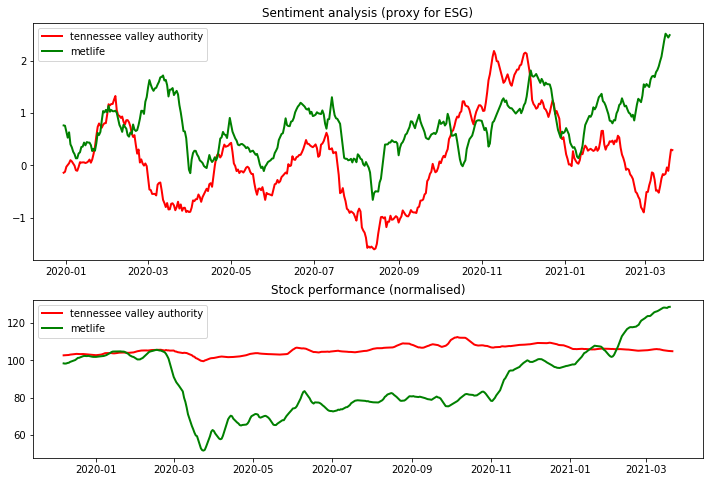

In [ ]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}, figsize=(12, 8))
colors = ['red', 'green']

for i in range(0,2):
  
  # retrieve sentiment time series
  organisation = organisations[i]
  org_df = gdelt_data[gdelt_data['organisation'] == organisation].drop('organisation', axis=1).sort_values('date')
  org_df = org_df.set_index('date')
  org_df = org_df.asfreq(freq = 'D', method = 'pad')

  # retrieve stock time series
  symbol = symbols[i]
  sym_df = stock_esg[stock_esg['symbol'] == symbol].drop('symbol', axis=1).sort_values('date')
  sym_df = sym_df.set_index('date')
  sym_df = sym_df.asfreq(freq = 'D', method = 'pad')
  sym_df['close'] = 100 * sym_df['close'] / sym_df.iloc[0].close
  
  # align 2 dates
  sym_df = sym_df.reindex(org_df.index)

  # plot both series in subplots
  axs[0].plot(org_df.index, org_df.rolling(window=30).mean().tone, linewidth=2, label=organisation, color=colors[i])
  axs[1].plot(sym_df.index, sym_df.rolling(window=7).mean().close, linewidth=2, label=organisation, color=colors[i])
  
# plot graph
axs[0].title.set_text('Sentiment analysis (proxy for ESG)')
axs[1].title.set_text('Stock performance (normalised)')
axs[0].tick_params(axis='x', which='both', bottom='off', labelbottom='off')
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
display(fig)

In [ ]:
%python

from pyspark.sql.functions import *

organisation = 'santander'
# we retrieve sentiment analysis data for these 2 organisations
gdelt_data = spark \
  .read \
  .table('esg_db.gdelt_gold') \
  .filter(F.col('organisation').isin(organisation)) \
  .groupBy('date', 'organisation') \
  .agg(F.sum("tone").alias("tone"), F.sum("total").alias("total")) \
  .withColumn("tone", F.col("tone") / F.col("total")) \
  .select('date', 'organisation', 'tone') \
  .toPandas()

#Saving required dataframe data to intermediary source table
# retrieve sentiment time series

org_df = gdelt_data[gdelt_data['organisation'] == organisation].drop('organisation', axis=1).sort_values('date')
org_df = org_df.set_index('date')
org_df = org_df.asfreq(freq = 'D', method = 'pad')

# retrieve stock time series
symbol = 'SAN'
sym_df = stock_esg[stock_esg['symbol'] == symbol].drop('symbol', axis=1).sort_values('date')
sym_df = sym_df.set_index('date')
sym_df = sym_df.asfreq(freq = 'D', method = 'pad')
sym_df['close'] = 100 * sym_df['close'] / sym_df.iloc[0].close
sym_df = sym_df.reindex(org_df.index)

performance_df = sym_df
performance_df['30DaysSentimentValue'] = org_df.rolling(window=30).mean().tone
performance_df['7DaysStockPrice'] = sym_df.rolling(window=7).mean().close
performance_df = performance_df[['30DaysSentimentValue','7DaysStockPrice']]
performance_df.reset_index(inplace=True)
performance_df = spark.createDataFrame(performance_df)
performance_df = performance_df.withColumn('organisation', lit(organisation))

performance_df \
.write \
.mode("append") \
.format("delta") \
.saveAsTable("esg_db.srcEsgSentimentVsMarketPerformance")

In [ ]:
%sql
SELECT DISTINCT Organisation FROM esg_db.srcEsgSentimentVsMarketPerformance ORDER BY 1 DESC

Organisation
santander
morgan stanley
macquarie
lloyds
jp morgan chase
goldman sachs
citi
barclays


In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger

//read data from source table
val streamDf = spark 
  .readStream                                                  // Reading as a stream, processing record since last check point
  .format("delta")                                              // Reading from a delta table
  .table("esg_db.srcEsgSentimentVsMarketPerformance")  //Main source table
  .withColumn("IsMigrated", lit(0)) 

//Create a chekpoint of last insertion
streamDf
  .writeStream                                                                  // Writing data as a stream
  .trigger(Trigger.Once)                                                       // Create a streaming job triggered only once...
  .option("checkpointLocation", "/esg_checkpoint/dbrEsgSentimentVsMarketPerformance_5") //Don't change checkpoint location (processes data since last checkpoint)
  .format("delta")                                                              // write to delta table
  .table("esg_db.dbrEsgSentimentVsMarketPerformance")   //Save to intermediary Databricks table

import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger
streamDf: org.apache.spark.sql.DataFrame = [date: timestamp, 30DaysSentimentValue: double ... 3 more fields]
res7: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@10ba14b1

In [ ]:
%sql
SELECT DISTINCT Organisation, IsMigrated FROM esg_db.dbrEsgSentimentVsMarketPerformance ORDER BY 1 DESC

Organisation,IsMigrated
santander,0
morgan stanley,0
macquarie,0
lloyds,0
jp morgan chase,0
goldman sachs,0
citi,0
barclays,0


In [ ]:
%scala
// //Configuration settings to connect to blob storage
// spark.conf.set( "fs.azure.account.key.#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net", "#STORAGE_ACCOUNT_KEY#"))

// //declaring the credentials
// val sqluser =  dbutils.secrets.get(scope="esgmigratecreds", key="sqluser")
// val sqlpassword = dbutils.secrets.get(scope="esgmigratecreds", key="sqlpassword")
// val dbtable = "ADB_EsgSentimentVsMarketPerformance" //Synapse Table Name Set here
// val url = s"jdbc:sqlserver://#WORKSPACE_NAME#.sql.azuresynapse.net:1433;database=#DATABASE_NAME#;user=#SQL_USERNAME#;password=#SQL_PASSWORD#;encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword"

// //Read only newer records from our intermediary table in Databricks
// var migrate_df = spark.sql("SELECT Date, 30DaysSentimentValue, 7DaysStockPrice, Organisation, current_timestamp() as ReportedOn FROM esg_db.dbrEsgSentimentVsMarketPerformance WHERE IsMigrated = 0")
 
// print(s"Total Records", migrate_df.count())
// print("\n")

// //Send new records to synapse for further processing
// migrate_df.write.format("com.databricks.spark.sqldw").option("forwardSparkAzureStorageCredentials", "true").mode("append").option("url", url).option("dbtable", dbtable).option("tempDir", "abfss://esg-migrate@#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net/tempDirs").save()

// //Mark records as migrated after successfully saved to synapase
// spark.sql("UPDATE esg_db.dbrEsgSentimentVsMarketPerformance SET IsMigrated = 1 WHERE IsMigrated = 0")

(Total Records,3895)
sqluser: String = [REDACTED]
sqlpassword: String = [REDACTED]
dbtable: String = ADB_EsgSentimentVsMarketPerformance
url: String = jdbc:sqlserver://marketdatasynapse.sql.azuresynapse.net:1433;database=FSIRiskDW;user=[REDACTED];password=[REDACTED];encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword
migrate_df: org.apache.spark.sql.DataFrame = [Date: timestamp, 30DaysSentimentValue: double ... 3 more fields]
res13: org.apache.spark.sql.DataFrame = []

As reported in the graph above, despite an evident lack of data to draw scientific conclusions, it would appear that our highest and lowest ESG rated companies (we report the sentiment analysis as a proxy of ESG in the top graph) are respectively the best or worst profitable instruments in our portfolio over the last 18 months. Interestingly, [csrhub](https://www.csrhub.com/) reports the exact opposite, `pearson` being 10 points above `prologis`, highlighting the subjectivity of ESG and its inconsistency between what was communicated and what is actually observed.

In the section below, we run an hypothetical scenario where our synthetic portfolio is split into 2 books where each one is respectively composed of the best and worst 10% of our ESG rated instruments. For each book, we report its historical returns and its corresponding 95% value-at-risk (historical VaR).

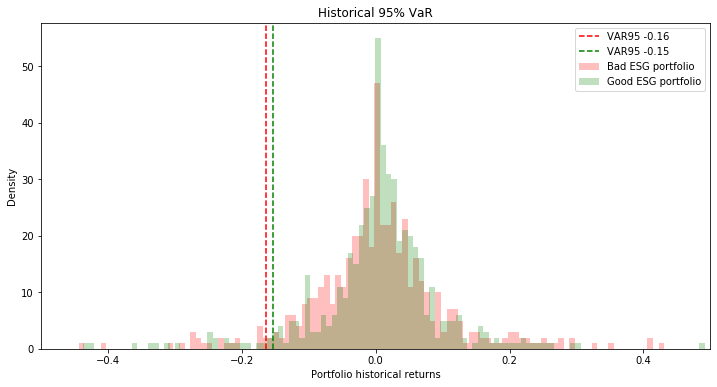

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize = (12, 6))

# create 5 different books for each ESG quantile, aggregating individual returns
grouped_assets = stock_esg.groupby(['class', 'date']).sum()

# retrieve poorly rated ESG portfolio and compute historical value at risk
bronze_portfolio = grouped_assets.loc['1']
bronze_var = np.quantile(bronze_portfolio['return'], 5 / 100)
plt.hist(bronze_portfolio['return'], bins=200, alpha=0.25, color='red', label='Bad ESG portfolio')
plt.axvline(bronze_var, color='red', linestyle='--', label="VAR95 {:.2f}".format(bronze_var))

# retrieve highly rated ESG portfolio and compute historical value at risk
gold_portfolio = grouped_assets.loc['5']
gold_var = np.quantile(gold_portfolio['return'], 5 / 100)
plt.hist(gold_portfolio['return'], bins=200, alpha=0.25, color='green', label='Good ESG portfolio')
plt.axvline(gold_var, color='green', linestyle='--', label="VAR95 {:.2f}".format(gold_var))

# plot graph
plt.xlim(-0.5,0.5)
plt.legend(loc='upper right')
plt.xlabel('Portfolio historical returns')
plt.ylabel('Density')
plt.title('Historical 95% VaR')
display(fig)

Without any prior knowledge of our instruments beyond the metrics we extracted through our framework, we can observe a risk exposure to be 2 times higher for a portfolio made of poor ESG rated companies, supporting the assumptions found in the literature that ”*poor ESG [...] correlates with higher market volatility*”, hence to a greater value-at-risk. Using the flexibility of cloud compute and the level of interactivity in your data enabled through our Databricks runtime, risk analysts can better understand the risk facing their business by slicing and dicing market risk calculations at different industries, countries, segments, and now at different ESGs ratings. This data-driven ESG framework enables businesses to ask new questions such as: how much of your risk would be decreased by bringing the environmental rating of this company up 10 points? How much more exposure would you face by investing in these instruments given their low ESG scores?

In [ ]:
%sh ls /dbfs/FileStore/


jars
plots
reports.csv
tables